# E-commerce Product recommendation System

In [1]:

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics import mean_squared_error

from scipy.sparse.linalg import svds # for sparse matrices

In [2]:
#Import the data set
df = pd.read_csv(r'C:\Users\HP\Downloads\py\Recommendation System\ratings_Electronics.csv', header=None) #There are no headers in the data file

df.columns = ['user_id', 'prod_id', 'rating', 'timestamp'] #Adding column names

In [3]:
df.head()

,user_id,prod_id,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [4]:
df = df.drop('timestamp', axis=1) #Dropping timestamp

df_copy = df.copy(deep=True) #Copying the data to another dataframe

**EDA - Exploratory Data Analysis**
check for -

- shape
- datatype
- missing values

finally get the summary and check

- rating distribution 
- number of users and products.
- Users with highest no of ratings.

**Shape**

In [5]:

rows, columns = df.shape
print("No of rows = ", rows)
print("No of columns = ", columns)

No of rows =  7824482
No of columns =  3


**Datatypes**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   prod_id  object 
 2   rating   float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


**Missing value analysis**



In [7]:

# Find number of missing values in each column
df.isna().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

**Summary**





In [10]:

# Summary statistics of 'rating' variable
df['rating'].describe()

count    7.824482e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

# Rating distribution

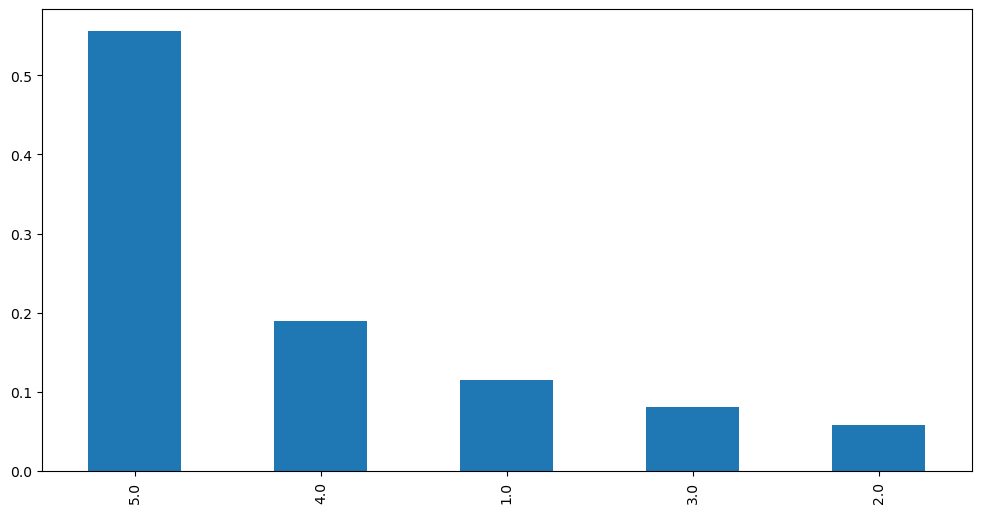

In [13]:
plt.figure(figsize=(12,6))

df['rating'].value_counts(1).plot(kind='bar')
plt.show()

The distribution is skewed to the right. Over 50% of the ratings are 5, followed by a little below 20% with 4 star ratings. And the percentages of ratings keep going down until below 10% of the ratings are 2 stars.

# No of unique users and items

In [14]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', df['prod_id'].nunique())
     

Number of unique USERS in Raw data =  4201696
Number of unique ITEMS in Raw data =  476002


# Users with most no of rating

In [15]:
top_n_users = df.groupby('user_id').size().sort_values(ascending=False)[:10]

In [16]:
top_n_users

user_id
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
dtype: int64

# Pre-Processing
Let's take a subset of the dataset (by only keeping the users who have given 50 or more ratings) to make the dataset less sparse and easy to work with.

In [17]:

counts = df['user_id'].value_counts()
counts.head()

A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
Name: user_id, dtype: int64

In [18]:
df_final = df[df['user_id'].isin(counts[counts >= 50].index)]

In [20]:
df_final.shape

(125871, 3)

In [21]:
print('The number of observations in the final data =', len(df_final))
print('Number of unique USERS in the final data = ', df_final['user_id'].nunique())
print('Number of unique PRODUCTS in the final data = ', df_final['prod_id'].nunique())

The number of observations in the final data = 125871
Number of unique USERS in the final data =  1540
Number of unique PRODUCTS in the final data =  48190


- The dataframe df_final has users who have rated 50 or more items
- We will use df_final to build recommendation systems



# Checking the density of the rating matrix

Here are the reasons and benefits of creating a pivot table for a recommendation system:

- 1 Structured Data:
Pivot tables help in structuring the data in a way that makes it easy to analyze and use for recommendations. For example, in a user-item interaction scenario, you want to create a matrix where rows represent users and columns represent items, with the cell values representing interactions (e.g., ratings, purchases, views).

- 2 Sparsity Handling:
Recommendation systems often deal with sparse data. Pivot tables help in managing sparsity by clearly showing which users have interacted with which items. This sparse matrix can then be used to fill missing values through various imputation methods or by using algorithms designed to handle sparsity.

- 3 Compatibility with Algorithms:
Many collaborative filtering algorithms, such as matrix factorization or neighborhood-based methods, require input data in the form of a user-item matrix. Creating a pivot table is an essential step to convert raw interaction data into this matrix form.

**Utility Matrix based on products sold and user reviews**
**Utility Matrix**

An utlity matrix is consists of all possible user-item preferences (ratings) details represented as a matrix. The utility matrix is sparce as none of the users would buy all teh items in the list, hence, most of the values are unknown.

In [22]:
#Creating the interaction matrix of products and users based on ratings and replacing NaN value with 0
final_ratings_matrix = df_final.pivot(index = 'user_id', columns ='prod_id', values = 'rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

#Finding the number of non-zero entries in the interaction matrix 
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)

#Finding the possible number of ratings as per the number of users and products
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)

#Density of ratings
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

final_ratings_matrix.head()

Shape of final_ratings_matrix:  (1540, 48190)
given_num_of_ratings =  125871
possible_num_of_ratings =  74212600
density: 0.17%


prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


As expected, the utility matrix obtained above is sparce, I have filled up the unknown values wth 0.

# 1 Rank Based Recommendation System

In [26]:

#Calculate the average rating for each product 
average_rating= df_final.groupby('prod_id').mean()['rating']

#Calculate the count of ratings for each product

count_rating = df_final.groupby('prod_id').count()['rating']


#Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

#Sort the dataframe by average of ratings
final_rating = final_rating.sort_values(by='avg_rating',ascending=False)

final_rating.head()

,avg_rating,rating_count
prod_id,,
0594451647,5.0,1
B003RRY9RS,5.0,1
B003RR95Q8,5.0,1
B003RIPMZU,5.0,1
B003RFRNYQ,5.0,2


In [27]:
#defining a function to get the top n products based on highest average rating and minimum interactions


def top_n_products(final_rating, n, min_interaction):
    
    #Finding products with minimum number of interactions
    recommendations = final_rating[final_rating['rating_count']>min_interaction]
    
    #Sorting values w.r.t average rating 
    recommendations = recommendations.sort_values('avg_rating',ascending=False)

    
    return recommendations.index[:n]
    


**case1: Recommending top 5 products with 50 minimum interactions based on popularity**



In [30]:
list(top_n_products(final_rating, 5, 50))

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

**Case2: Recommending top 5 products with 100 minimum interactions based on popularity**

In [31]:

list(top_n_products(final_rating, 5, 100))
     

['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC']

# 2 Collaborative Filtering based Recommendation System

# 2A: User based collaborative filtering

In [33]:
final_ratings_matrix.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Here, user_id (index) is of the object data type. We will replace the user_id by numbers starting from 0 to 1539 (for all user ids) so that the index is of integer type and represents a user id in the same format**

In [34]:
final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
final_ratings_matrix.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Function to find Similar users and their similarity scores**





In [36]:
# defining a function to get similar users
def similar_users(user_index, interactions_matrix):
    similarity = []
    for user in range(0, interactions_matrix.shape[0]): #  .shape[0] gives number of rows
        
        #finding cosine similarity between the user_id and each user
        sim = cosine_similarity([interactions_matrix.loc[user_index]], [interactions_matrix.loc[user]])
        
        #Appending the user and the corresponding similarity score with user_id as a tuple
        similarity.append((user,sim))
        
    similarity.sort(key=lambda x: x[1], reverse=True)
    most_similar_users = [tup[0] for tup in similarity] #Extract the user from each tuple in the sorted list
    similarity_score = [tup[1] for tup in similarity] ##Extracting the similarity score from each tuple in the sorted list
   
    #Remove the original user and its similarity score and keep only other similar users 
    most_similar_users.remove(user_index)
    similarity_score.remove(similarity_score[0])
       
    return most_similar_users, similarity_score

**Finding out top 10 similar users to the user index 3 and their similarity score**

In [37]:
similar = similar_users(3,final_ratings_matrix)[0][0:10]
similar

[320, 12, 793, 261, 156, 1493, 1250, 567, 753, 1360]

In [38]:
#Print the similarity score
similar_users(3,final_ratings_matrix)[1][0:10]

[array([[0.05662371]]),
 array([[0.05549645]]),
 array([[0.05098326]]),
 array([[0.05024185]]),
 array([[0.05003874]]),
 array([[0.04930111]]),
 array([[0.04889354]]),
 array([[0.04672744]]),
 array([[0.04637283]]),
 array([[0.04492668]])]

**Finding out top 10 similar users to the user index 1521 and their similarity score**

In [39]:
similar = similar_users(1521, final_ratings_matrix)[0][0:10]
similar
     

[991, 1065, 1012, 1402, 1371, 1278, 1518, 692, 785, 161]

In [43]:

#Print the similarity score
similar_users(1521,final_ratings_matrix)[1][0:10]

[array([[0.10889304]]),
 array([[0.10538068]]),
 array([[0.1026758]]),
 array([[0.09418291]]),
 array([[0.09149062]]),
 array([[0.09135361]]),
 array([[0.09028898]]),
 array([[0.08735684]]),
 array([[0.08673386]]),
 array([[0.08478815]])]

**Function to find n similar users having x threshold value of cosine similarity to main user**

In [64]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

def find_users_with_similarities(interactions_matrix, cosine_sim_value, min_similar_users):
    # Step 1: Compute cosine similarities
    similarities = cosine_similarity(interactions_matrix, interactions_matrix)

    # Step 2: Filter users based on cosine similarity threshold
    similar_users_mask = similarities > cosine_sim_value
    np.fill_diagonal(similar_users_mask, False)  # Exclude self-similarity
    
    # Step 3: Find main users with at least min_similar_users similar users
    main_users = []
    for user_index in range(interactions_matrix.shape[0]):
        # Find indices of users with similarity above threshold
        similar_indices = np.where(similar_users_mask[user_index])[0]
        
        # Filter based on minimum number of similar users
        if len(similar_indices) >= min_similar_users:
            main_users.append({
                'userid': user_index,
                'similar_users': list(similar_indices),
                'cosine_scores': list(similarities[user_index, similar_indices])
            })
    
    return main_users


In [97]:
 
# Example function call with cosine_sim_value = 0.2 and min_similar_users = 3
results = find_users_with_similarities(final_ratings_matrix, 0.2, 3)


In [98]:

# Print results in desired format
for result in results:
    print(f"userid: {result['userid']}, similar_users: {result['similar_users']}, cosine_scores: {result['cosine_scores']}\n")


userid: 418, similar_users: [817, 834, 904, 996, 1065, 1237, 1518], cosine_scores: [0.2031222621020754, 0.20106868496343772, 0.27173802112055223, 0.21090148602399902, 0.27603145008271085, 0.21470228293677157, 0.21266317410674188]

userid: 633, similar_users: [904, 996, 1065], cosine_scores: [0.20222738762708453, 0.22701662131443492, 0.2550990479940635]

userid: 692, similar_users: [834, 904, 1065, 1371, 1518], cosine_scores: [0.20956886567526298, 0.20344622405245158, 0.21966638114736659, 0.25701150477746254, 0.2392895449099897]

userid: 834, similar_users: [418, 692, 904, 1065, 1371], cosine_scores: [0.20106868496343772, 0.20956886567526298, 0.24267743660024263, 0.21793794712259118, 0.28219603509240027]

userid: 904, similar_users: [392, 418, 633, 692, 834, 870, 996, 1065, 1237, 1371, 1518], cosine_scores: [0.23495688266322762, 0.27173802112055223, 0.20222738762708453, 0.20344622405245158, 0.24267743660024263, 0.20228252238151345, 0.2293987035774005, 0.25128545446167455, 0.228342182638

**Function to recommend products**: 
**so the above list of similar user can be used in below recommend function to recommend them items similar to high cosine similar value users etc**

The function recommendations is designed to generate personalized recommendations for a given user based on their similarity to other users in terms of their interactions with products/items.

In [89]:
# Redefining the recommendations function to get recommendations by using the similar users' preferences
def recommendations(user_index, num_of_products, interactions_matrix, cosine_sim_value):
    
    # Saving similar users using the function similar_users defined above
    most_similar_users, _ = similar_users(user_index, interactions_matrix, cosine_sim_value)
    
    # Finding product IDs with which the user_id has interacted
    prod_ids = set(interactions_matrix.columns[np.where(interactions_matrix.loc[user_index] > 0)])
    recommendations = []
    
    observed_interactions = prod_ids.copy()
    for similar_user in most_similar_users:
        if len(recommendations) < num_of_products:
            
            # Finding 'n' products which have been rated by similar users but not by the user_id
            similar_user_prod_ids = set(interactions_matrix.columns[np.where(interactions_matrix.loc[similar_user] > 0)])
            recommendations.extend(list(similar_user_prod_ids.difference(observed_interactions)))
            observed_interactions = observed_interactions.union(similar_user_prod_ids)
        else:
            break
    
    return recommendations[:num_of_products]

**Recommend x products to user index y based on similarity based collaborative filtering**

In [92]:
# Example function call to get 5 recommendations for user index 3 with cosine similarity threshold 0.2
recs = recommendations(817, 5, final_ratings_matrix, 0.2)

print(f"Recommendations for user 418: {recs}")

Recommendations for user 418: ['B00BGIQPSG', 'B004BLIQ5K', 'B00F1CRTLK', 'B00EVNVRM2', 'B0057UUB1G']


**Summary of above function**
In summary, the recommendations function leverages user similarity based on their interactions (interactions_matrix) to suggest products/items (num_of_products) that similar users have interacted with but the target user (user_index) has not. It uses cosine similarity to identify similar users and provides personalized recommendations based on this similarity measure. Adjustments to cosine_sim_value and num_of_products can tailor the recommendations to different levels of similarity and quantity of recommendations desired.

 

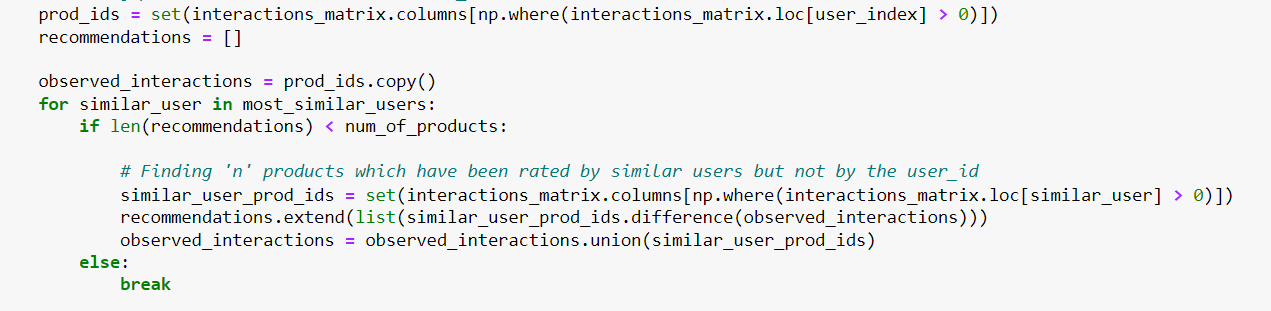

- Iterates through the most similar users (most_similar_users).
- For each similar user (similar_user), identifies the products/items they have interacted with (similar_user_prod_ids).
- Adds products/items that the similar user has interacted with but user_index(main passed user) has not (similar_user_prod_ids.difference(observed_interactions)) to the recommendations list.
- Updates observed_interactions to include products/items from the current similar user to avoid recommending duplicates.
- Stops once num_of_products recommendations are generated or when there are no more similar users left (len(recommendations) < num_of_products).

# 2B : Model based Collaborative Filtering: Singular Value Decomposition

**We have seen above that the interaction matrix is highly sparse. SVD is best to apply on a large sparse matrix. Note that for sparse matrices, we can use the sparse.linalg.svds() function to perform the decomposition**

**Also, we will use k=50 latent features to predict rating of products**

**CSR Matrix**

**CSR matrix** stands for Compressed Sparse Row matrix. It's a popular format used to efficiently store and manipulate sparse matrices in computer memory. Here's a breakdown of its key characteristics:

**Sparse Matrix**
A sparse matrix is a matrix that is populated mostly with zeros. In many real-world applications, matrices representing relationships or interactions between entities (like users and items in recommendation systems, or words and documents in natural language processing) are sparse because each entity typically interacts with only a small subset of all possible entities.

**Compressed Sparse Row (CSR) Matrix**
The CSR matrix format is designed to efficiently store sparse matrices by only storing the non-zero elements and their indices

In [103]:

from scipy.sparse import csr_matrix
final_ratings_sparse = csr_matrix(final_ratings_matrix.values)

In [104]:
final_ratings_sparse.shape

(1540, 48190)

**SVD**

SVD is a powerful matrix factorization technique used in various applications such as dimensionality reduction, data reconstruction, and collaborative filtering. It provides insights into the underlying structure of data by decomposing matrices into orthogonal components and is widely applied in diverse fields including machine learning, signal processing, and statistics.

In [106]:

# Singular Value Decomposition
U, s, Vt = svds(final_ratings_sparse, k = 50) # here k is the number of latent features

# Construct diagonal array in SVD
sigma = np.diag(s)
     

In [107]:

U.shape

(1540, 50)

In [108]:
sigma.shape

(50, 50)

In [109]:

Vt.shape

(50, 48190)

**Now, let's regenerate the original matrix using U, Sigma, and Vt matrices. The resulting matrix would be the predicted ratings for all users and products**

**Predicting ratings**

In [110]:

all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df = pd.DataFrame(abs(all_user_predicted_ratings), columns = final_ratings_matrix.columns)

preds_matrix = csr_matrix(preds_df.values)

In [111]:
preds_df.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.005086,0.002178,0.003668,0.040843,0.009640,0.006808,0.020659,0.000649,0.020331,0.005633,...,0.000238,0.061477,0.001214,0.123433,0.028490,0.016109,0.002855,0.174568,0.011367,0.012997
1,0.002286,0.010898,0.000724,0.130259,0.007506,0.003350,0.063711,0.000674,0.016111,0.002433,...,0.000038,0.013766,0.001473,0.025588,0.042103,0.004251,0.002177,0.024362,0.014765,0.038570
2,0.001655,0.002675,0.007355,0.007264,0.005152,0.003986,0.003480,0.006961,0.006606,0.002719,...,0.001708,0.051040,0.000325,0.054867,0.017870,0.004996,0.002426,0.083928,0.112205,0.005964
3,0.001856,0.011019,0.005910,0.014134,0.000179,0.001877,0.005391,0.001709,0.004968,0.001402,...,0.000582,0.009326,0.000465,0.048315,0.023302,0.006790,0.003380,0.005460,0.015263,0.025996
4,0.001115,0.002670,0.011018,0.014434,0.010319,0.006002,0.017151,0.003726,0.001404,0.005645,...,0.000207,0.023761,0.000747,0.019347,0.012749,0.001026,0.001364,0.020580,0.011828,0.012770


**Function to recommend products**



In [135]:

import numpy as np

def recommend_items(user_index, interactions_matrix, preds_matrix, num_recommendations):
    
    # Get the user's ratings from the actual and predicted interaction matrices
    user_ratings = interactions_matrix[user_index,:].toarray().reshape(-1)
    user_predictions = preds_matrix[user_index,:].toarray().reshape(-1)

    #Creating a dataframe with actual and predicted ratings columns
    temp = pd.DataFrame({'user_ratings': user_ratings, 'user_predictions': user_predictions})
    temp['Recommended Products'] = np.arange(len(user_ratings))
    temp = temp.set_index('Recommended Products')
    
    #Filtering the dataframe where actual ratings are 0 which implies that the user has not interacted with that product
    temp = temp.loc[temp.user_ratings == 0]   
    
    #Recommending products with top predicted ratings
    temp = temp.sort_values('user_predictions',ascending=False)#Sort the dataframe by user_predictions in descending order
    print('\nBelow are the recommended products with their predicted value for user(user_id = {}):\n'.format(user_index))
    print(temp['user_predictions'].head(num_recommendations))


**Recommending top 5 products to user id 121**



In [136]:

#Enter 'user index' and 'num_recommendations' for the user
recommend_items(121,final_ratings_sparse,preds_matrix,5)


Below are the recommended products with their predicted value for user(user_id = 121):

Recommended Products
28761    2.414390
39003    1.521306
41420    1.309224
40158    1.200111
33819    1.126866
Name: user_predictions, dtype: float64


**Predicted Value**

**The predicted ratings generated by collaborative filtering using techniques like Singular Value Decomposition (SVD) theoretically and in a business sense reflect the expected level of interest or preference a user may have for a particular product.** 

**Recommending top 10 products to user id 100**

In [116]:
recommend_items(100,final_ratings_sparse,preds_matrix,10)


Below are the recommended products for user(user_id = 100):

Recommended Products
11078    1.624746
16159    1.132730
10276    1.047888
22210    0.955049
18887    0.879705
41618    0.854430
45008    0.816153
43419    0.803755
28761    0.748799
14791    0.748797
Name: user_predictions, dtype: float64


**A changed Recommendation Function with predicted value passed**

In [133]:
def recommend_items(user_index, interactions_matrix, preds_matrix, num_recommendations, threshold=0.5):
    user_ratings = interactions_matrix[user_index,:].toarray().reshape(-1)
    user_predictions = preds_matrix[user_index,:].toarray().reshape(-1)

    temp = pd.DataFrame({'user_ratings': user_ratings, 'user_predictions': user_predictions})
    temp['Recommended Products'] = np.arange(len(user_ratings))
    temp = temp.set_index('Recommended Products')
    
    temp = temp.loc[(temp.user_ratings == 0) & (temp.user_predictions >= threshold)]   
    temp = temp.sort_values('user_predictions', ascending=False)
    
    print(f'\nBelow are the recommended products for user with predicted  value for each product (user_id = {user_index}):\n')
    print(temp['user_predictions'].head(num_recommendations))



In [134]:
# Example: Recommend top 5 products to user id 121 with predicted rating threshold of x value

recommend_items(121, final_ratings_sparse, preds_matrix, 5, threshold=1)



Below are the recommended products for user with predicted  value for each product (user_id = 121):

Recommended Products
28761    2.414390
39003    1.521306
41420    1.309224
40158    1.200111
33819    1.126866
Name: user_predictions, dtype: float64


**Analyze Predicted Ratings for Insights**

In the context of collaborative filtering using Singular Value Decomposition (SVD) for recommendation systems, leveraging predicted ratings to gain customer insights involves analyzing patterns and relationships between users and items. Here’s how you can approach this in the use case outlined earlier:

**Analyzing Predicted Ratings for Customer Insights**

- 1: Identify High-Rating Items:

Step: Compute and identify items with the highest predicted ratings across all users.
Why: Items with consistently high predicted ratings indicate products that are generally well-received or highly recommended by the system to a wide range of users.
Action: Use this insight to prioritize inventory, promotions, or feature prominently in recommendations.

    
- 2: Explore User-Specific Preferences:

Step: Analyze predicted ratings for specific users to understand their preferences.
Why: Patterns in individual user preferences can reveal niche markets or segments with distinct tastes.
Action: Tailor marketing campaigns or recommendations to better serve these segments, potentially increasing engagement and satisfaction.

- 3: Detect Trends and Seasonality:

Step: Track changes in predicted ratings over time or across different seasons or events.
Why: Trends in user preferences can highlight seasonal demands or emerging product interests.
Action: Adjust inventory, content offerings, or marketing strategies accordingly to capitalize on trends and meet customer expectations.

- 4: Segmentation and Targeting:

Step: Cluster users based on their predicted ratings profiles (e.g., using clustering algorithms like K-means).
Why: Segmentation helps in identifying groups of users with similar preferences or behaviors.
Action: Create targeted marketing campaigns or personalized recommendations tailored to each segment’s preferences, enhancing relevance and engagement.

- 5: Cross-Sell and Upsell Opportunities:

Step: Analyze co-occurrence patterns of high-rated items among users.
Why: Identify complementary or higher-value items that users tend to prefer together.
Action: Recommend related products to increase cross-sell opportunities or promote higher-value items to drive revenue.

**Practical Implementation**
In your specific use case with the collaborative filtering system:

- Compute and Visualize Trends: Use analytics tools or visualizations to plot trends in predicted ratings over time or across different user segments.

- Segmentation Analysis: Apply clustering techniques to group users based on their predicted ratings profiles and derive actionable insights for each segment.

- Pattern Recognition: Use association rule mining or frequent itemset mining to uncover relationships between high-rated items and identify potential product bundles or recommendations.

- Feedback Loop: Incorporate feedback mechanisms to refine the predictive models based on user interactions and continuously improve recommendations.

By systematically analyzing predicted ratings from your collaborative filtering model, you can uncover valuable customer insights that inform strategic decisions, improve customer satisfaction, and drive business growth. These insights help in understanding user preferences, optimizing product offerings, and enhancing the overall user experience.

In [138]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


In [139]:
top_rated_items = preds_df.max().sort_values(ascending=False)

In [140]:
# Example: Cluster users based on predicted ratings
kmeans = KMeans(n_clusters=5)  # Example clustering, adjust as needed
preds_df['Cluster'] = kmeans.fit_predict(preds_df)


In [142]:
preds_df.columns

Index(['0594451647', '0594481813', '0970407998', '0972683275', '1400501466',
       '1400501520', '1400501776', '1400532620', '1400532655', '140053271X',
       ...
       'B00L8I6SFY', 'B00L8QCVL6', 'B00LA6T0LS', 'B00LBZ1Z7K', 'B00LED02VY',
       'B00LGN7Y3G', 'B00LGQ6HL8', 'B00LI4ZZO8', 'B00LKG1MC8', 'Cluster'],
      dtype='object', name='prod_id', length=48191)

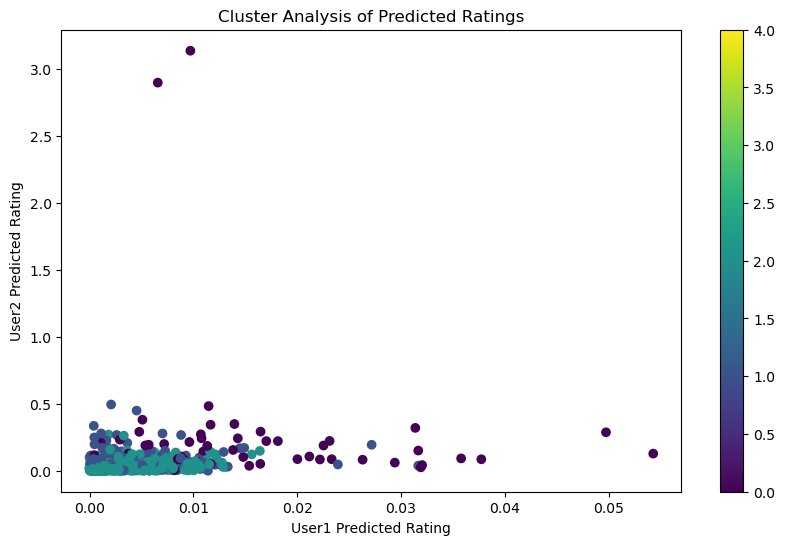

In [143]:
# Plot clusters based on two dimensions (for illustration)
plt.figure(figsize=(10, 6))
plt.scatter(preds_df['0594451647'], preds_df['B00LA6T0LS'], c=preds_df['Cluster'], cmap='viridis')
plt.xlabel('User1 Predicted Rating')
plt.ylabel('User2 Predicted Rating')
plt.title('Cluster Analysis of Predicted Ratings')
plt.colorbar()
plt.show()

Business Action: Based on insights, take actions such as prioritizing inventory for top-rated items, tailoring marketing campaigns for different user clusters, or identifying cross-sell opportunities.

 Analyze the resulting clusters to understand patterns in user preferences or behaviors based on their predicted ratings. This can guide strategic decisions such as targeted marketing, product recommendations, or customer segmentation strategies.

# Evaluating the model

In [117]:
final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
final_ratings_matrix.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [119]:
average_rating = final_ratings_matrix.mean()
average_rating.head()
     

prod_id
0594451647    0.003247
0594481813    0.001948
0970407998    0.003247
0972683275    0.012338
1400501466    0.012987
dtype: float64

In [120]:
preds_df.head()
     

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.005086,0.002178,0.003668,0.040843,0.009640,0.006808,0.020659,0.000649,0.020331,0.005633,...,0.000238,0.061477,0.001214,0.123433,0.028490,0.016109,0.002855,0.174568,0.011367,0.012997
1,0.002286,0.010898,0.000724,0.130259,0.007506,0.003350,0.063711,0.000674,0.016111,0.002433,...,0.000038,0.013766,0.001473,0.025588,0.042103,0.004251,0.002177,0.024362,0.014765,0.038570
2,0.001655,0.002675,0.007355,0.007264,0.005152,0.003986,0.003480,0.006961,0.006606,0.002719,...,0.001708,0.051040,0.000325,0.054867,0.017870,0.004996,0.002426,0.083928,0.112205,0.005964
3,0.001856,0.011019,0.005910,0.014134,0.000179,0.001877,0.005391,0.001709,0.004968,0.001402,...,0.000582,0.009326,0.000465,0.048315,0.023302,0.006790,0.003380,0.005460,0.015263,0.025996
4,0.001115,0.002670,0.011018,0.014434,0.010319,0.006002,0.017151,0.003726,0.001404,0.005645,...,0.000207,0.023761,0.000747,0.019347,0.012749,0.001026,0.001364,0.020580,0.011828,0.012770


In [121]:

avg_preds=preds_df.mean()
avg_preds.head()

prod_id
0594451647    0.003360
0594481813    0.005729
0970407998    0.008566
0972683275    0.035330
1400501466    0.006966
dtype: float64

In [122]:
rmse_df = pd.concat([average_rating, avg_preds], axis=1)

rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']

rmse_df.head()

,Avg_actual_ratings,Avg_predicted_ratings
prod_id,,
0594451647,0.003247,0.003360
0594481813,0.001948,0.005729
0970407998,0.003247,0.008566
0972683275,0.012338,0.035330
1400501466,0.012987,0.006966


In [123]:

RMSE=mean_squared_error(rmse_df['Avg_actual_ratings'], rmse_df['Avg_predicted_ratings'], squared=False)
print(f'RMSE SVD Model = {RMSE} \n')

RMSE SVD Model = 0.013679389779858013 

